# 序列模型

https://zh.d2l.ai/chapter_recurrent-neural-networks/sequence.html

- 时序模型中当前数据跟之前观察到的数据相关
- 使用自身过去书去预测未来
- 马尔可夫模型假设当前只跟最近少数数据相关，从而简化模型
- 潜变量模型使用潜变量来概括历史信息

## 1. 使用简单MLP进行拟合

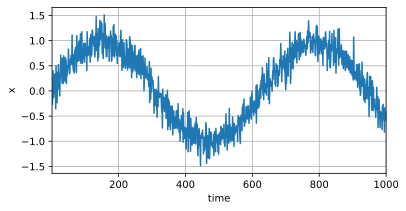

In [8]:
'''准备数据'''
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000 # 共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(mean=0, std=0.2, size = (T, ))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))


In [9]:
'''将此序列转换为模型的特征-标签(feature-label)
简化模型，只与前Tau个数据有关
'''
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [15]:
'''使用一个拥有两个全连接层的MLP，ReLU激活函数和MSELoss损失（平方损失）'''
# 初始化网络权重参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight) # 使用均匀分布初始化函数的权重

# MLP
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

# 平方损失，MSELoss计算平凡误差时，不带系数1/2
loss = nn.MSELoss(reduction='none')

def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.075355
epoch 2, loss: 0.058008
epoch 3, loss: 0.056236
epoch 4, loss: 0.055193
epoch 5, loss: 0.054443


## 2. 预测
首先是检查模型预测下一个时间步的能力， 也就是单步预测（one-step-ahead prediction）

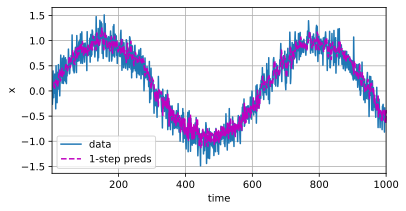

In [16]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

正如我们所料，单步预测效果不错。 即使这些预测的时间步超过了600+4（n_train + tau）， 其结果看起来仍然是可信的。 然而有一个小问题：如果数据观察序列的时间步只到604， 我们需要一步一步地向前迈进：
$$
\begin{aligned}
\hat{x}_{605} &= f(\hat{x}_{601}, \hat{x}_{602}, \hat{x}_{603}, \hat{x}_{604}), \\
\hat{x}_{606} &= f(\hat{x}_{602}, \hat{x}_{603}, \hat{x}_{604}, \hat{x}_{605}), \\
\hat{x}_{607} &= f(\hat{x}_{603}, \hat{x}_{604}, \hat{x}_{605}, \hat{x}_{606}), \\
\hat{x}_{608} &= f(\hat{x}_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}), \\
\hat{x}_{609} &= f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}), \\
& \vdots
\end{aligned}
$$
通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$称为$k$步预测（$k$-step-ahead-prediction）。 由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{t+k}$。 换句话说，我们必须使用我们自己的预测（而不是原始数据）来进行多步预测。 让我们看看效果如何。

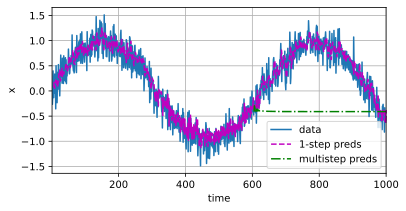

In [17]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

绿线代表预测，预测结果并不李现，因为存在累计错误，所以会导致精度迅速下降

基于$k=1,4,16,64$，通过对整个序列预测的计算，$k$步预测困难如下

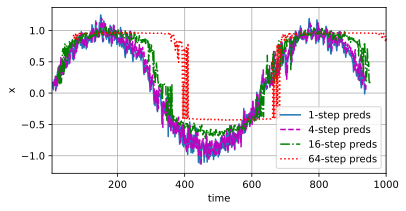

In [22]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

## 3. 总结
- 内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。
- 序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。
- 对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。
- 对于直到时间步$t$的观测序列，其在时间步$t+k$的预测输出是“$k$步预测”。随着我们对预测时间$k$值的增加，会造成误差的快速累积和预测质量的极速下降。